# Behavioral Cloning - Self-Driving Car ND Project

## Introduction

In this project, a technique called end-to-end learning will be discussed. Using a provided simulator, I'll record driving data according to my behavior behind the wheel, and then I'll train a deep network to mimic my way of driving and learn how to drive in the simulator by itself.

## Data collection

The simulator collects data from three cameras mounted on the windshield of the car (left, center and right cameras). It also records the steering angle associated with each set of images and it records approximately 10 data points (three images plus a steering angle) per second.

Training the network with only regular driving data might not be sufficient, because the network might never learn how to recover from a mistake. One way of improving this issue is to augment the data by using the left and right images and add corrective biases to their associated steering angle (this method was used is this NVIDIA paper: http://images.nvidia.com/content/tegra/automotive/images/2016/solutions/pdf/end-to-end-dl-using-px.pdf).

Another method, which was used here, is to collect data while driving somewhat irregularly. Data was recorded with the car drinving on the edges of the track and also going in the reverse direction of the track (to balance the total number of left and right turns).

## Data visualization

In [1]:
### Import necessary packages
import numpy as np
import pandas as pd
import cv2
from os.path import basename, isfile
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def visualize_dataset(file_name):
    dataset = pd.read_csv(file_name, header=0)
    time = np.linspace(0., dataset.shape[0]/10., num=dataset.shape[0])
    plt.plot(time, dataset['steering'][:])
    return dataset

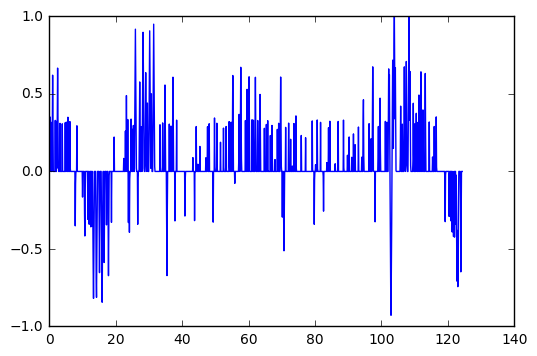

In [3]:
center_rev = visualize_dataset('track1/full_center_rev1/driving_log.csv')

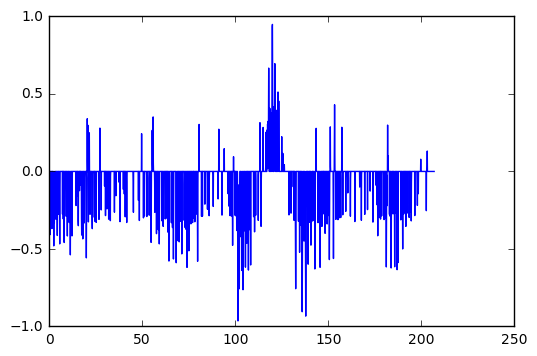

In [4]:
center = visualize_dataset('track1/full_center1/driving_log.csv')

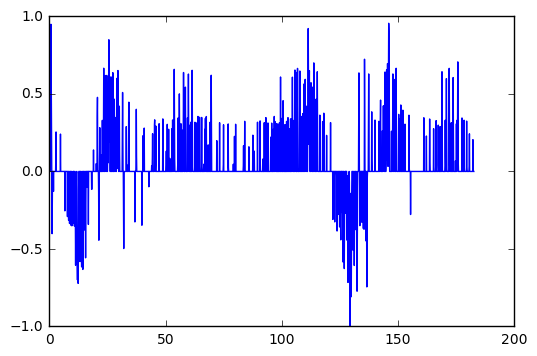

In [5]:
to_left_rev = visualize_dataset('track1/full_toLeft_rev1/driving_log.csv')

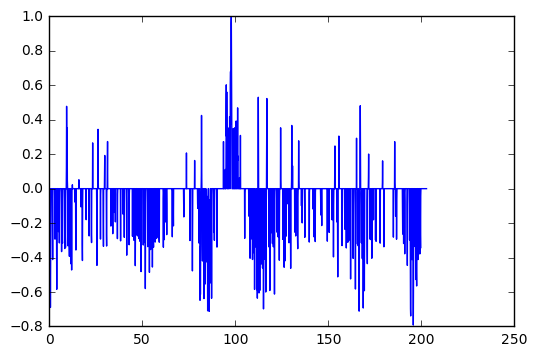

In [6]:
to_left = visualize_dataset('track1/full_toLeft1/driving_log.csv')

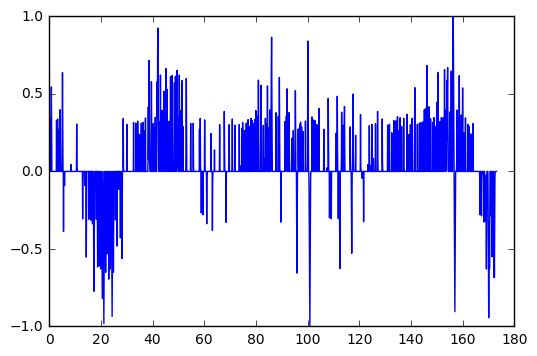

In [7]:
to_right_rev = visualize_dataset('track1/full_toRight_rev1/driving_log.csv')

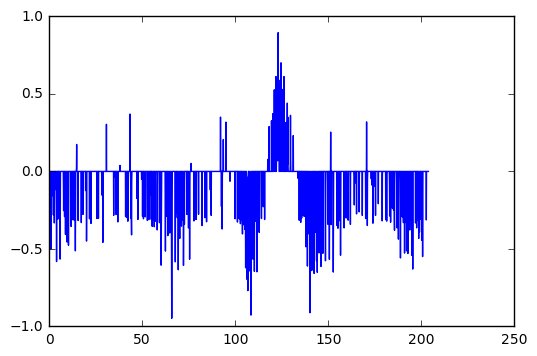

In [8]:
to_right = visualize_dataset('track1/full_toRight1/driving_log.csv')

## Data preparation

In [9]:
def add_bias(dataset, bias=0.):
    steering_data = dataset + bias
    steering_data = np.append(steering_data, dataset + 0.1 + bias, axis=0)
    steering_data = np.append(steering_data, dataset - 0.1 + bias, axis=0)
    return steering_data

def read_images(dataset):
    img_data = np.empty((dataset.shape[0], 32, 32, 3))
    for i in range(dataset.shape[0]):
        img = cv2.imread('IMG/' + basename(dataset[i]))
        img_data[i, :, :, :] = cv2.resize(img, (32, 32), interpolation=cv2.INTER_AREA)
    return img_data

def load_from_log(driving_log_df, bias=0.):
    img_data = read_images(driving_log_df['center'])
    img_data = np.append(img_data, read_images(driving_log_df['left']), axis=0)
    img_data = np.append(img_data, read_images(driving_log_df['right']), axis=0)
    steering_data = add_bias(driving_log_df['steering'], bias=bias)
    return img_data, steering_data

def concat_data(dataset_list):
    final_dataset = dataset_list[0]
    for i in range(1, len(dataset_list)):
        final_dataset = np.append(final_dataset, dataset_list[i], axis=0)
    return final_dataset

In [10]:
pickle_file = 'train_data.pickle'

if isfile(pickle_file):
        print('File already exists.')
        with open(pickle_file, mode='rb') as f:
            train = pickle.load(f)
        img_train = train['img']
        steering_train = train['steering']
else:
    c_img, c_steering = load_from_log(center)
    c_rev_img, c_rev_steering = load_from_log(center_rev)

    tL_img, tL_steering = load_from_log(to_left, bias=-0.2)
    tL_rev_img, tL_rev_steering = load_from_log(to_left_rev, bias=-0.2)

    tR_img, tR_steering = load_from_log(to_right, bias=0.2)
    tR_rev_img, tR_rev_steering = load_from_log(to_right_rev, bias=0.2)

    img_train = concat_data([c_img, c_rev_img,
                             tL_img, tL_rev_img,
                             tR_img, tR_rev_img])
    steering_train = concat_data([c_steering, c_rev_steering,
                                 tL_steering, tL_rev_steering,
                                 tR_steering, tR_rev_steering])

print(img_train.shape, steering_train.shape)

File already exists.
(32805, 32, 32, 3) (32805,)


In [11]:
if isfile(pickle_file):
        print('File already exists. Skipping pickling...')
else:
    print('Pickling...')
    try:
        f = open(pickle_file, 'wb')
        save = {
            'img': img_train,
            'steering': steering_train,
        }
        pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
        f.close()
    except Exception as e:
        print('Unable to save data to', pickle_file, ':', e)
        raise

File already exists. Skipping pickling...


In [ ]:
### Shuffle the data
from sklearn.utils import shuffle

img_train, steering_train = shuffle(img_train, steering_train)

In [ ]:
### Normalize the image data
img_train = img_train/255. - 0.5

## Network architecture

In [ ]:
from keras.models import Sequential
from keras.layers.core import Dense, Flatten, Activation
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D

# Fix error with TF and Keras
import tensorflow as tf
tf.python.control_flow_ops = tf

model.Sequential()
model.add(Convolution2D(8, 1, 1, border_mode='valid', input_shape=(32, 32, 3)))
model.add(Activation('relu'))
model.add(Convolution2D(16, 3, 3, border_mode='valid'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(32, 1, 1, border_mode='valid'))
model.add(Activation('relu'))
model.add(Convolution2D(64, 3, 3, border_mode='valid'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(32, 1, 1, border_mode='valid'))
model.add(Activation('relu'))
model.add(Convolution2D(128, 3, 3, border_mode='valid'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dense(1))

## Training and Evaluation

In [ ]:
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(img_train, steering_train, nb_epoch=20, validation_split=0.2)